# CE-VAE + TUDA Feature-Level Alignment Training

This notebook fine-tunes the CE-VAE model with TUDA-style feature-level adversarial alignment.

**What this does:** Adds a feature-level discriminator that teaches the encoder to produce domain-invariant features, improving generalization on diverse real-world underwater images.

**Requirements:**
- Kaggle (T4 GPU, ~30h/week free) or Google Colab (T4 GPU)
- ~2 hours training time
- LSUI dataset + UIEB real underwater images

**Steps:**
1. Setup environment
2. Upload/download datasets
3. Train the TUDA-enhanced model
4. Evaluate and compare with baseline

## 1. Environment Setup

In [4]:
# Check GPU availability
!nvidia-smi
import torch
print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Mon Feb 16 08:58:12 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# Clone the repository
!git clone https://github.com/priyanshuharshbodhi1/ce-vae-tuda-underwater-enhancement.git
%cd ce-vae-tuda-underwater-enhancement


Cloning into 'ce-vae-tuda-underwater-enhancement'...
remote: Enumerating objects: 217, done.
remote: Counting objects: 100% (217/217), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 217 (delta 91), reused 201 (delta 75), pack-reused 0 (from 0)
Receiving objects: 100% (217/217), 24.28 MiB | 39.28 MiB/s, done.
Resolving deltas: 100% (91/91), done.
/kaggle/working/ce-vae-tuda-underwater-enhancement/ce-vae-tuda-underwater-enhancement


In [6]:
# Install dependencies
!pip install -q albumentations lightning omegaconf opencv-python-headless \
    'jsonargparse[signatures]>=4.27.7' Pillow pytorch-msssim torchmetrics wandb scikit-image termcolor lpips

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 853.6/853.6 kB 18.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.1/246.1 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.5/760.5 kB 41.1 MB/s eta 0:00:00


## 2. Dataset Setup

You need:
1. **LSUI dataset** (paired: degraded + ground truth) — for standard CE-VAE training
2. **UIEB real images** (unpaired) — for TUDA feature alignment
3. **Pre-trained CE-VAE checkpoint** — as starting point

In [7]:
# 2. Dataset Setup (ROBUST AUTO-LINKING)
import os
import glob
from pathlib import Path

os.makedirs('data', exist_ok=True)

def link_path(src, dst):
    if os.path.exists(dst):
        if os.path.islink(dst): os.unlink(dst)
        else: return # skip folders
    os.symlink(src, dst)
    print(f'✅ Linked {src} -> {dst}')

print('Searching for datasets in /kaggle/input (this may take a few seconds)...')

# --- 1. Robust Search for LSUI ---
lsui_dirs = glob.glob('/kaggle/input/**/LSUI', recursive=True)
if lsui_dirs:
    lsui_root = lsui_dirs[0]
    link_path(os.path.join(lsui_root, 'input'), 'data/input')
    link_path(os.path.join(lsui_root, 'GT'), 'data/GT')
else:
    print('⚠️ LSUI folder not found in /kaggle/input (searching for internal folders...)')
    input_search = glob.glob('/kaggle/input/**/input', recursive=True)
    gt_search = glob.glob('/kaggle/input/**/GT', recursive=True)
    if input_search and gt_search:
        link_path(input_search[0], 'data/input')
        link_path(gt_search[0], 'data/GT')

# --- 2. Robust Search for UIEB ---
uieb_search = glob.glob('/kaggle/input/**/raw-890', recursive=True)
if uieb_search:
    link_path(uieb_search[0], 'data/real_underwater')
else:
    print('⚠️ UIEB (raw-890) not found. Checking root titles...')
    root_scan = glob.glob('/kaggle/input/**/UIEB*', recursive=True)
    if root_scan: link_path(root_scan[0], 'data/real_underwater')

# --- 3. Robust Search for Checkpoint ---
ckpt_search = glob.glob('/kaggle/input/**/*.ckpt', recursive=True)
if ckpt_search:
    link_path(ckpt_search[0], 'data/lsui-cevae-epoch119.ckpt')
else:
    print('⚠️ Checkpoint (.ckpt) not found in /kaggle/input')

print('\n--- Automated Dataset Indexing ---')
def create_list_file(img_dir, out_file, label):
    if os.path.exists(img_dir):
        paths = sorted(glob.glob(os.path.join(img_dir, '**', '*.*'), recursive=True))
        paths = [p for p in paths if p.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        with open(out_file, 'w') as f:
            f.write('\n'.join(paths))
        print(f'✅ Generated {out_file} ({len(paths)} {label} images)')
    else: print(f'❌ Cannot index {label}: {img_dir} missing')

# Generate train/val splits for LSUI (80/20 split of whatever is found)
if os.path.exists('data/input') and os.path.exists('data/GT'):
    inputs = sorted(glob.glob('data/input/*.*'))
    targets = sorted(glob.glob('data/GT/*.*'))
    if len(inputs) == len(targets) and len(inputs) > 0:
        split_idx = int(0.9 * len(inputs)) # Using 90/10 for more training data
        # Train
        with open('data/LSUI_train_input.txt', 'w') as f: f.write('\n'.join(inputs[:split_idx]))
        with open('data/LSUI_train_target.txt', 'w') as f: f.write('\n'.join(targets[:split_idx]))
        # Val
        with open('data/LSUI_val_input.txt', 'w') as f: f.write('\n'.join(inputs[split_idx:]))
        with open('data/LSUI_val_target.txt', 'w') as f: f.write('\n'.join(targets[split_idx:]))
        print(f'✅ LSUI Indexed: {split_idx} train, {len(inputs)-split_idx} val samples')

create_list_file('data/real_underwater', 'data/real_underwater_images.txt', 'Real Unpaired')

print('\nFinal Data Check:')
!ls -la data/

Searching for datasets in /kaggle/input (this may take a few seconds)...
✅ Linked /kaggle/input/datasets/noureldin199/lsui-large-scale-underwater-image-dataset/LSUI/input -> data/input
✅ Linked /kaggle/input/datasets/noureldin199/lsui-large-scale-underwater-image-dataset/LSUI/GT -> data/GT
✅ Linked /kaggle/input/datasets/larjeck/uieb-dataset-raw/raw-890 -> data/real_underwater
✅ Linked /kaggle/input/datasets/priyanshuharshbodhi/lsui-cevae-epoch119-ckpt/lsui-cevae-epoch119.ckpt -> data/lsui-cevae-epoch119.ckpt

--- Automated Dataset Indexing ---
✅ LSUI Indexed: 3851 train, 428 val samples
✅ Generated data/real_underwater_images.txt (890 Real Unpaired images)

Final Data Check:
total 208
drwxr-xr-x  2 root root  4096 Feb 16 08:58 .
drwxr-xr-x 10 root root  4096 Feb 16 08:58 ..
lrwxrwxrwx  1 root root    85 Feb 16 08:58 GT -> /kaggle/input/datasets/noureldin199/lsui-large-scale-underwater-image-dataset/LSUI/GT
lrwxrwxrwx  1 root root    88 Feb 16 08:58 input -> /kaggle/input/datasets/nour

In [8]:
# Verify everything is in place
required_files = [
    'data/lsui-cevae-epoch119.ckpt',
    'data/LSUI_train_input.txt',
    'data/LSUI_train_target.txt', 
    'data/LSUI_val_input.txt',
    'data/LSUI_val_target.txt',
    'data/real_underwater_images.txt',
]

all_good = True
for f in required_files:
    exists = os.path.exists(f)
    status = '✅' if exists else '❌'
    print(f"{status} {f}")
    if not exists:
        all_good = False

if all_good:
    print("\n🎉 All files ready! Proceed to training.")
else:
    print("\n⚠️ Some files are missing. Please upload them before training.")

✅ data/lsui-cevae-epoch119.ckpt
✅ data/LSUI_train_input.txt
✅ data/LSUI_train_target.txt
✅ data/LSUI_val_input.txt
✅ data/LSUI_val_target.txt
✅ data/real_underwater_images.txt

🎉 All files ready! Proceed to training.


## 3. Training

Fine-tune CE-VAE with TUDA feature alignment. Expected time: **~1.5-2 hours on T4**.

In [19]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
WANDB_API_KEY = user_secrets.get_secret("wandb")


In [21]:
# Optional: Login to Weights & Biases for experiment tracking
# If you don't have a W&B account, you can skip this (training still works)
import wandb
import os
# try:
#     wandb.login(key=WANDB_API_KEY)
#     # wandb.login(key=os.environ["wandb"])

# except:
#     print("W&B login skipped. Training will still run but without online logging.")
#     os.environ['WANDB_MODE'] = 'offline'

try:
    wandb.login(key=WANDB_API_KEY)
except:
    print("W&B login skipped...")


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.


W&B login skipped...


In [22]:
# from kaggle_secrets import UserSecretsClient
# import wandb

user_secrets = UserSecretsClient()
WANDB_API_KEY = user_secrets.get_secret("wandb")

wandb.login(key=WANDB_API_KEY)


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.


ValueError: API key must be 40 characters long, yours was 86

In [23]:
# Pull the latest fixes
!git pull


Already up to date.


In [24]:
# Start training!
!python main.py -cfg configs/cevae_E2E_lsui_tuda.yaml --trainer.max_epochs 10

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [26]:
 # wandb sync ./training_logs/2026-02-16T09-09-37_cevae_E2E_lsui_tuda/wandb/offline-run-20260216_090942-2026-02-16T09-09-37_cevae_E2E_lsui_tuda

In [27]:
!ls -d training_logs/*

training_logs/2026-02-16T08-58-57_cevae_E2E_lsui_tuda
training_logs/2026-02-16T09-09-37_cevae_E2E_lsui_tuda


In [28]:
# Find the best checkpoint
import glob
ckpt_files = sorted(glob.glob('training_logs/*/checkpoints/*.ckpt'))
print("Available checkpoints:")
if not ckpt_files:
    print("  ⚠️ No checkpoints found! Training may not have completed.")
    print("  Skipping evaluation cells below.")
    BEST_CKPT = None
else:
    for c in ckpt_files:
        size_mb = os.path.getsize(c) / (1024**2)
        print(f"  {c} ({size_mb:.1f} MB)")
    BEST_CKPT = [c for c in ckpt_files if 'last' in c][-1] if any('last' in c for c in ckpt_files) else ckpt_files[-1]
    print(f"\nUsing checkpoint: {BEST_CKPT}")

Available checkpoints:
  training_logs/2026-02-16T09-09-37_cevae_E2E_lsui_tuda/checkpoints/epoch=0004.ckpt (1003.7 MB)
  training_logs/2026-02-16T09-09-37_cevae_E2E_lsui_tuda/checkpoints/epoch=0009.ckpt (1003.7 MB)
  training_logs/2026-02-16T09-09-37_cevae_E2E_lsui_tuda/checkpoints/last.ckpt (1003.7 MB)

Using checkpoint: training_logs/2026-02-16T09-09-37_cevae_E2E_lsui_tuda/checkpoints/last.ckpt


## 4. Evaluation & Comparison

Compare the TUDA-enhanced model against the original CE-VAE baseline.

In [29]:
# Evaluate both models on the same test set
import sys
sys.path.insert(0, '.')

import torch
import numpy as np
from PIL import Image
from omegaconf import OmegaConf
from src.build.from_config import instantiate_from_config
from src.metrics import compute as compute_metrics
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_model(config_path, ckpt_path):
    """Load a CE-VAE model from config and checkpoint."""
    config = OmegaConf.load(config_path)
    config.model.params.ckpt_path = None
    if 'real_images_list_file' in config.model.params:
        config.model.params.real_images_list_file = None
    if 'real_images_dir' in config.model.params:
        config.model.params.real_images_dir = None
    model = instantiate_from_config(config.model)
    sd = torch.load(ckpt_path, map_location='cpu', weights_only=False)['state_dict']
    model.load_state_dict(sd, strict=False)
    return model.eval().to(device)

if BEST_CKPT is None:
    print('⚠️ Skipping model loading - no TUDA checkpoint found (training did not complete).')
    model_baseline = None
    model_tuda = None
else:
    print("Loading baseline CE-VAE...")
    model_baseline = load_model('configs/cevae_E2E_lsui.yaml', 'data/lsui-cevae-epoch119.ckpt')
    print("Loading TUDA-enhanced CE-VAE...")
    model_tuda = load_model('configs/cevae_E2E_lsui_tuda.yaml', BEST_CKPT)
    print("Both models loaded!")

Loading baseline CE-VAE...
Loading TUDA-enhanced CE-VAE...
Both models loaded!


In [30]:
if model_baseline is None or model_tuda is None:
    print('⚠️ Skipping evaluation - models were not loaded.')
else:
    # Run evaluation on validation set
    from torch.utils.data import DataLoader
    from src.data.image_enhancement import DatasetTestFromImageFileList
    
    # Load test dataset
    test_dataset = DatasetTestFromImageFileList(
        size=256,
        test_images_list_file='data/LSUI_val_input.txt',
        test_target_images_list_file='data/LSUI_val_target.txt'
    )
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)
    
    def evaluate_model(model, loader, name):
        """Evaluate a model and return average metrics."""
        metrics_sum = {'psnr': 0, 'ssim': 0, 'uiqm': 0, 'uciqe': 0}
        count = 0
        
        with torch.no_grad():
            for batch in tqdm(loader, desc=f'Evaluating {name}'):
                x = batch['image'].permute(0, 3, 1, 2).float().to(device)
                y = batch['target'].permute(0, 3, 1, 2).float().to(device)
                
                xrec = model(x)
                
                # Convert to numpy for metrics
                y_np = torch.clamp(y, -1, 1).detach().cpu()
                y_np = ((y_np + 1) / 2 * 255).permute(0, 2, 3, 1).numpy().astype(np.uint8)
                
                xrec_np = torch.clamp(xrec, -1, 1).detach().cpu()
                xrec_np = ((xrec_np + 1) / 2 * 255).permute(0, 2, 3, 1).numpy().astype(np.uint8)
                
                for rec, gt in zip(xrec_np, y_np):
                    res = compute_metrics(rec, gt)
                    for k in metrics_sum:
                        metrics_sum[k] += res[k]
                    count += 1
        
        return {k: v / count for k, v in metrics_sum.items()}
    
    print("Evaluating baseline...")
    baseline_metrics = evaluate_model(model_baseline, test_loader, 'Baseline CE-VAE')
    
    print("\nEvaluating TUDA-enhanced...")
    tuda_metrics = evaluate_model(model_tuda, test_loader, 'CE-VAE + TUDA')
    
    # Print comparison and save to file
    results_txt = ""
    header = f"{'Metric':<10} {'Baseline':>12} {'TUDA-Enhanced':>15} {'Δ':>10}\n" + "-"*50 + "\n"
    results_txt += "="*60 + "\nRESULTS COMPARISON\n" + "="*60 + "\n" + header
    
    print("\n" + "="*60)
    print("RESULTS COMPARISON")
    print("="*60)
    print(header.strip())
    
    for k in ['psnr', 'ssim', 'uiqm', 'uciqe']:
        delta = tuda_metrics[k] - baseline_metrics[k]
        arrow = '↑' if delta > 0 else '↓'
        line = f"{k.upper():<10} {baseline_metrics[k]:>12.4f} {tuda_metrics[k]:>15.4f} {arrow}{abs(delta):>8.4f}"
        print(line)
        results_txt += line + "\n"
    results_txt += "="*60 + "\n"
    
    with open('results_comparison.txt', 'w') as f:
        f.write(results_txt)
    print(f"\n✅ Results saved to results_comparison.txt")

Evaluating baseline...


Evaluating Baseline CE-VAE: 100%|██████████| 54/54 [01:55<00:00,  2.15s/it]



Evaluating TUDA-enhanced...


Evaluating CE-VAE + TUDA: 100%|██████████| 54/54 [02:00<00:00,  2.24s/it]


RESULTS COMPARISON
Metric         Baseline   TUDA-Enhanced          Δ
--------------------------------------------------
PSNR            28.9457         21.5976 ↓  7.3481
SSIM             0.8975          0.7964 ↓  0.1011
UIQM             3.0247          3.0332 ↑  0.0085
UCIQE            0.5640          0.5754 ↑  0.0114

✅ Results saved to results_comparison.txt


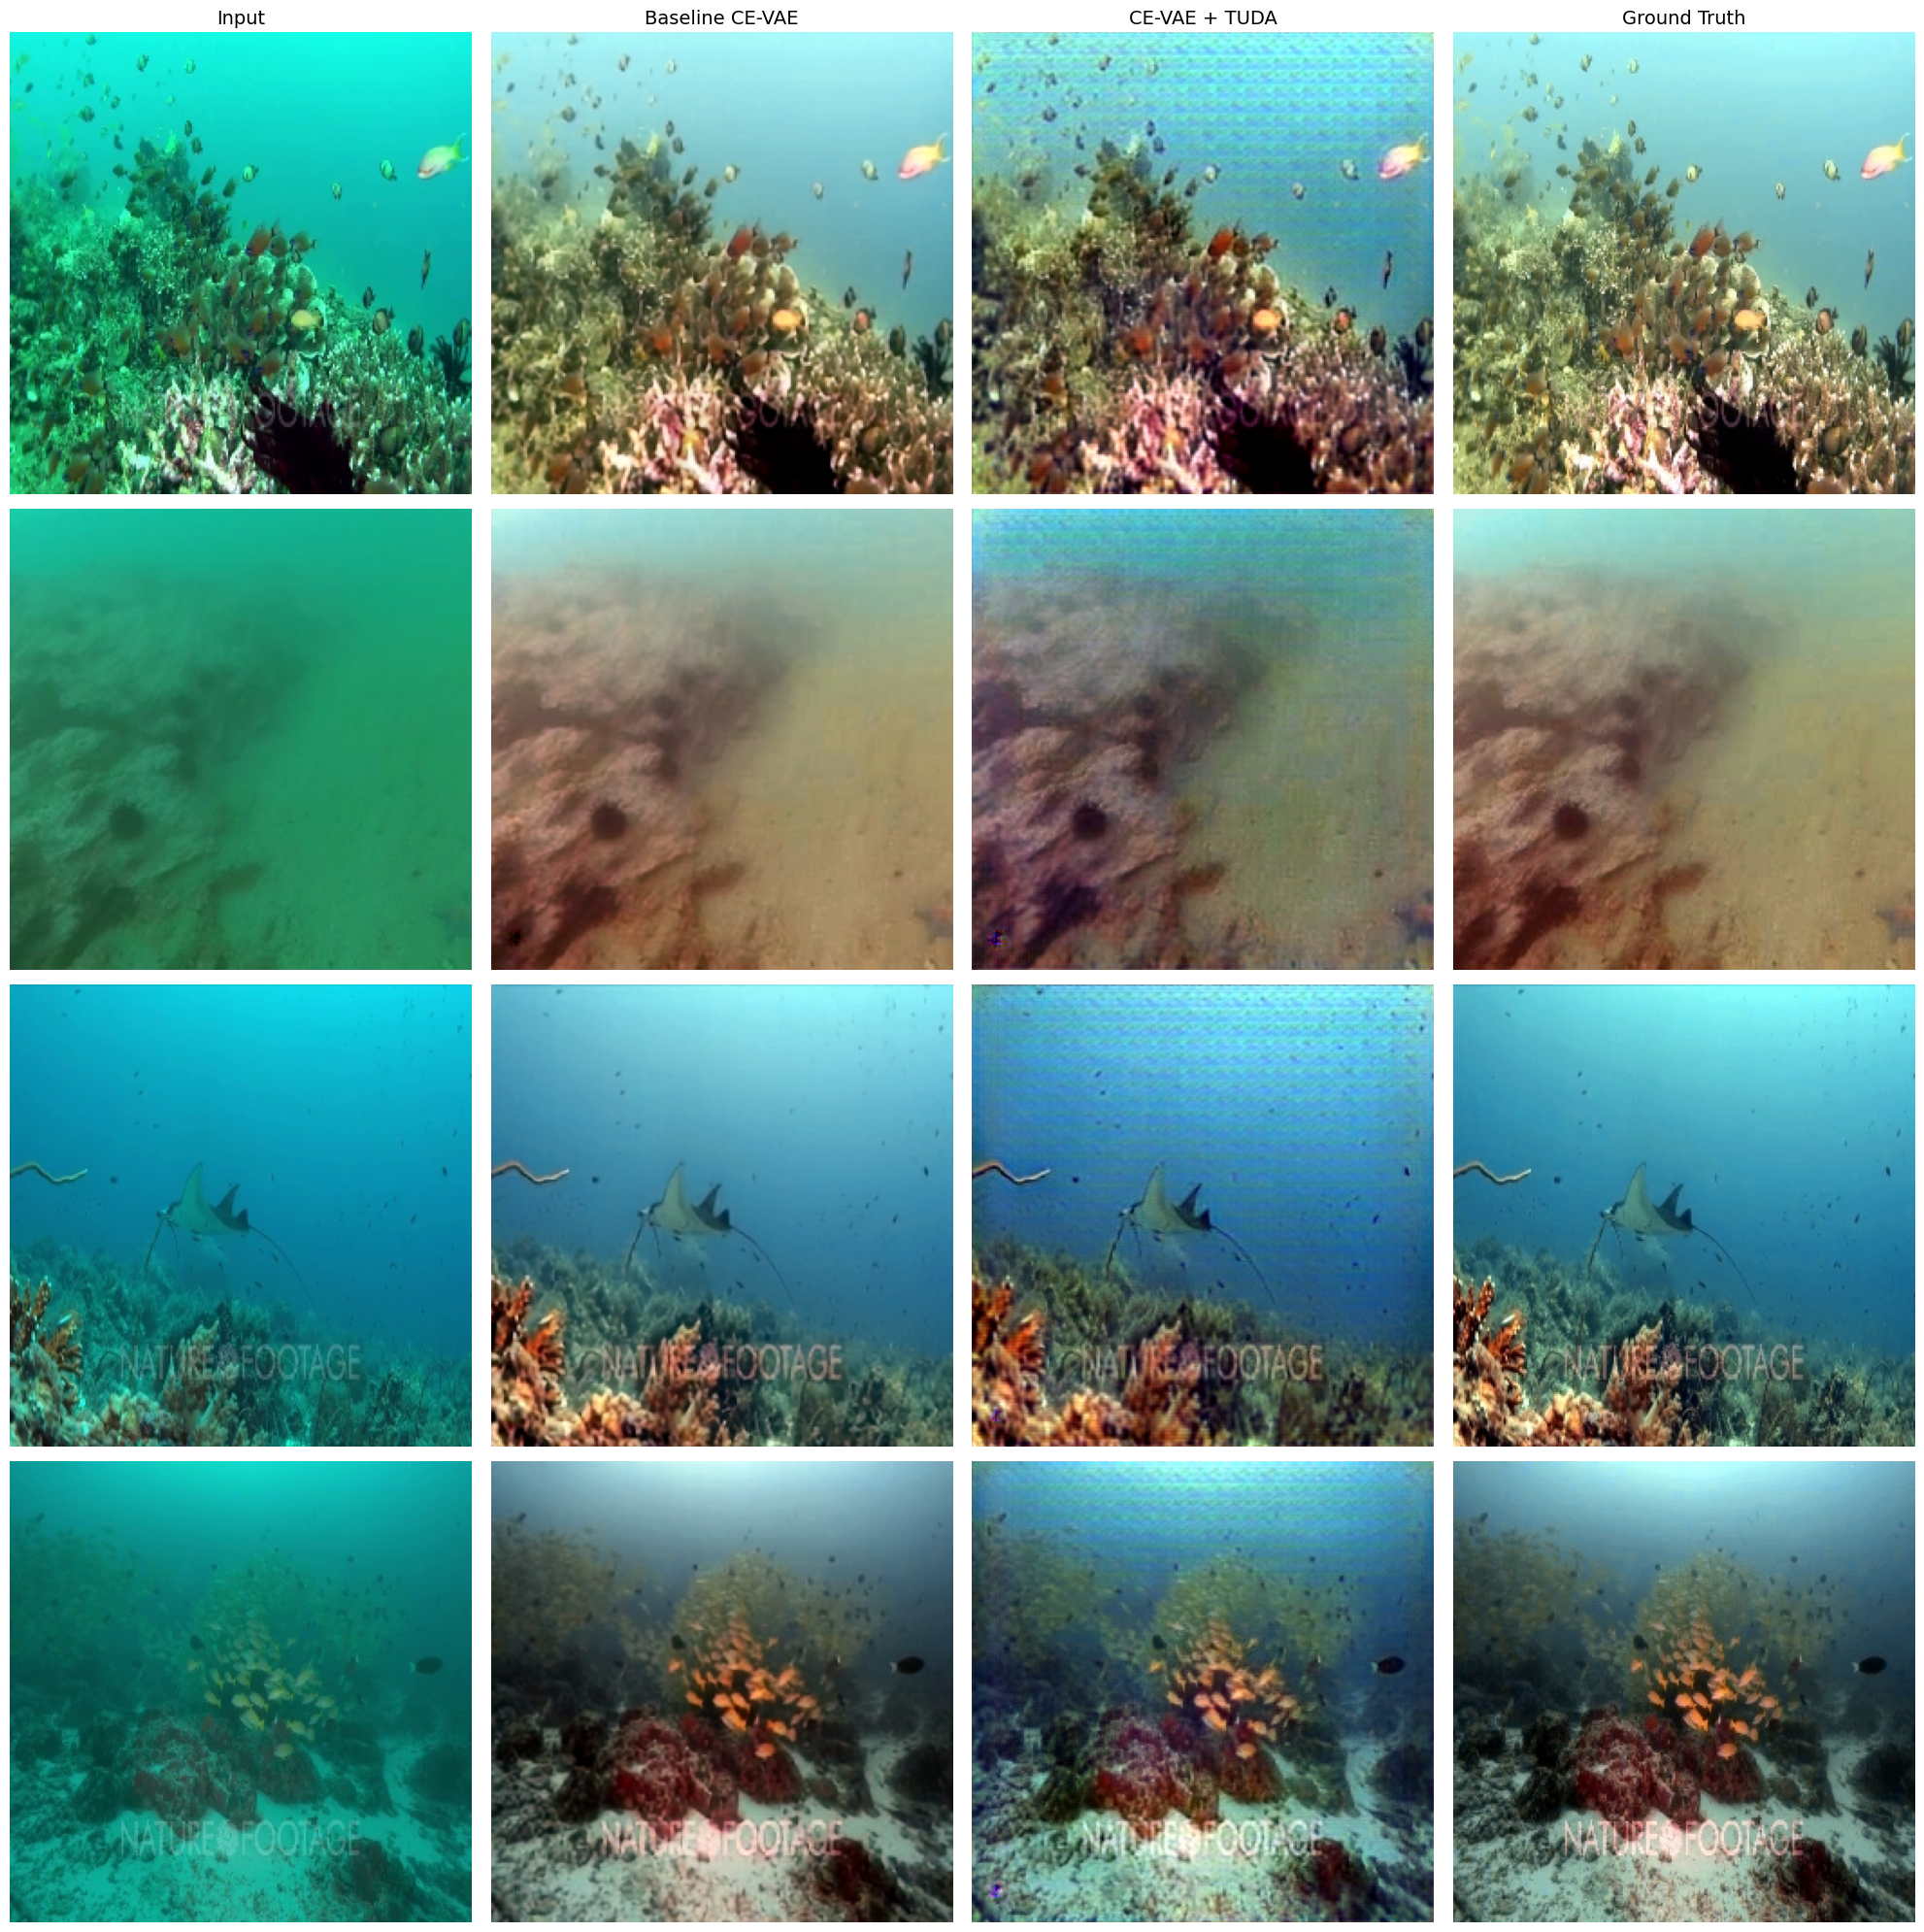


Comparison saved to comparison_results.png


In [31]:
if model_baseline is None or model_tuda is None:
    print('⚠️ Skipping visual comparison - models were not loaded.')
else:
    # Visual comparison
    import matplotlib.pyplot as plt
    
    # Get a few samples
    sample_batch = next(iter(DataLoader(test_dataset, batch_size=4, shuffle=True)))
    x = sample_batch['image'].permute(0, 3, 1, 2).float().to(device)
    y = sample_batch['target'].permute(0, 3, 1, 2).float().to(device)
    
    with torch.no_grad():
        rec_baseline = model_baseline(x)
        rec_tuda = model_tuda(x)
    
    def tensor_to_img(t):
        t = torch.clamp(t, -1, 1)
        return ((t + 1) / 2).cpu().permute(1, 2, 0).numpy()
    
    fig, axes = plt.subplots(4, 4, figsize=(20, 20))
    for i in range(4):
        axes[i, 0].imshow(tensor_to_img(x[i]))
        axes[i, 0].set_title('Input' if i == 0 else '', fontsize=14)
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(tensor_to_img(rec_baseline[i]))
        axes[i, 1].set_title('Baseline CE-VAE' if i == 0 else '', fontsize=14)
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(tensor_to_img(rec_tuda[i]))
        axes[i, 2].set_title('CE-VAE + TUDA' if i == 0 else '', fontsize=14)
        axes[i, 2].axis('off')
        
        axes[i, 3].imshow(tensor_to_img(y[i]))
        axes[i, 3].set_title('Ground Truth' if i == 0 else '', fontsize=14)
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.savefig('comparison_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\nComparison saved to comparison_results.png")

In [32]:
# Download the trained checkpoint
# For Kaggle: it will be saved in the output
# For Colab: download or save to Drive

import shutil
output_ckpt = 'cevae_tuda_finetuned.ckpt'
shutil.copy(BEST_CKPT, output_ckpt)
print(f"\n✅ Final checkpoint saved as: {output_ckpt}")
print(f"   Size: {os.path.getsize(output_ckpt) / (1024**2):.1f} MB")

# For Colab: uncomment to save to Google Drive
# shutil.copy(output_ckpt, '/content/drive/MyDrive/cevae_tuda_finetuned.ckpt')
# print("Saved to Google Drive!")


✅ Final checkpoint saved as: cevae_tuda_finetuned.ckpt
   Size: 1003.7 MB


In [33]:
import shutil
import glob
import os

# Find the last/best checkpoint
ckpt_files = sorted(glob.glob('training_logs/*/checkpoints/*.ckpt'))
if ckpt_files:
    BEST_CKPT = [c for c in ckpt_files if 'last' in c][-1] if any('last' in c for c in ckpt_files) else ckpt_files[-1]
    
    # Save a clean copy
    shutil.copy(BEST_CKPT, 'cevae_tuda_finetuned.ckpt')
    print(f"✅ Model saved to /kaggle/working/cevae_tuda_finetuned.ckpt")
    print("Now you can download it from the right-hand 'Output' pane.")
else:
    print("❌ No checkpoint found. Check the training_logs folder.")

✅ Model saved to /kaggle/working/cevae_tuda_finetuned.ckpt
Now you can download it from the right-hand 'Output' pane.
